In [12]:
import pandas as pd 
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [13]:
beer = pd.read_csv('/Users/salilketkar/thinkful/DS_Unit3/beer_reviews.csv')
beer_samp = beer.sample(n=100000,random_state = 20 )
print(beer_samp.head())
len(beer_samp)

         brewery_id                        brewery_name  review_time  \
1062146         125        Pennsylvania Brewing Company   1155862503   
306501           35  Boston Beer Company (Samuel Adams)   1205028118   
1582184         429                 Alaskan Brewing Co.   1278967517   
470622          392             Weyerbacher Brewing Co.   1113733462   
589876         1549               Goose Island Beer Co.   1205818875   

         review_overall  review_aroma  review_appearance review_profilename  \
1062146             4.0           3.5                4.0           brentk56   
306501              3.0           3.5                2.5          sjohansen   
1582184             4.0           3.0                3.5        unclejimbay   
470622              4.5           4.0                4.0      feloniousmonk   
589876              3.0           3.0                4.0        jeffmonarch   

                      beer_style  review_palate  review_taste  \
1062146     Märzen / Oktobe

100000

In [14]:
print('Before drop NA',len(beer_samp))
beer_samp.dropna(inplace=True)
print('After drop NA,',len(beer_samp))
beer_samp = beer_samp[(beer_samp['beer_abv'] <= 20) & (beer_samp['beer_abv'] > 0)]

Before drop NA 100000
After drop NA, 95777


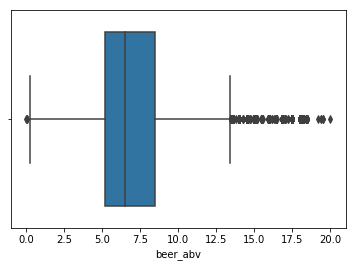

In [17]:
sns.boxplot(x='beer_abv',data=beer_samp)

## Linear Regression

In an effort to reduce the run time of the linear regression model, I have randomly sampled 100,000 data points using random state to ensure the sample does not change.

In [30]:
#feature engineering

beer_samp['review_overallSQ'] = beer_samp['review_overall'].apply(lambda x: x**(1/2))

beer_samp['review_palateSQ'] = beer_samp['review_palate'].apply(lambda x: np.sqrt(x**2))
beer_samp['review_tasteSQ'] = beer_samp['review_taste'].apply(lambda x: x**(3))

#linear regression
regr = linear_model.LinearRegression()
X = beer_samp[['review_overallSQ','review_palateSQ', 'review_tasteSQ']]
Y = beer_samp[['beer_abv']]
regr.fit(X,Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))




Coefficients: 
 [[-3.13771151  0.86102094  0.02621718]]

Intercept: 
 [8.31246485]

R-squared:
0.13893210898211783


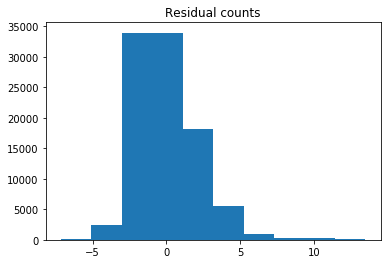

In [31]:
#multicolinearity
predicted = regr.predict(X).ravel()
actual=beer_samp['beer_abv']

residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.show()

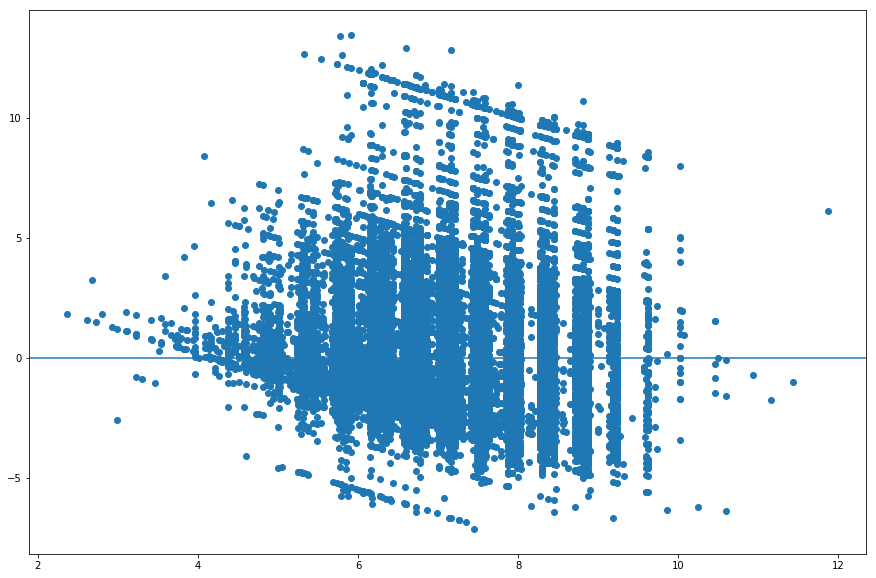

In [32]:
#homoscedascity

plt.figure(figsize=(15,10))
plt.scatter(predicted,residual)
plt.axhline(y=0)
plt.show()

In [33]:
correlation_matrix = X.corr()
print(correlation_matrix)

                  review_overallSQ  review_palateSQ  review_tasteSQ
review_overallSQ          1.000000         0.699956        0.711903
review_palateSQ           0.699956         1.000000        0.690145
review_tasteSQ            0.711903         0.690145        1.000000


In [34]:
# test statistics

import statsmodels.formula.api as smf
linear_formula = 'beer_abv ~ review_overall+review_palate+review_taste'
lm=smf.ols(formula=linear_formula, data=beer_samp).fit()
lm.params

Intercept         3.466080
review_overall   -1.008061
review_palate     0.828497
review_taste      1.133691
dtype: float64

In [35]:
lm.pvalues

Intercept         0.0
review_overall    0.0
review_palate     0.0
review_taste      0.0
dtype: float64

In [36]:
lm.rsquared

0.13409214706631256

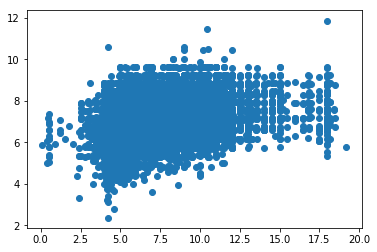

0.1366876567305717
Cross-validated scores: [0.13861456 0.14008861 0.14326822 0.13726944 0.14676141 0.12878381
 0.13829772 0.13257168 0.14197067 0.13915562]


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
#Cross validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


predictions = regr.predict(X_test)

plt.scatter(y_test, predictions)
plt.show()
print(regr.score(X_test, y_test))

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(regr,X, Y, cv=10)
print ('Cross-validated scores:', scores)

The plot and cross validation scores above show the quality of this linear regression.  The model does a very poor job of prediciting the target variable 'beer_abv'.  The features selected do not exactly follow a linear trend since the feature values are ratings between 0 and 5.  This does not give much room for the data to spread out and become linear.  The model doesn't overfit too much however all the accuracy scores are extremely low.  

## KNN

In [44]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=500,weights='distance')
X = pd.DataFrame(beer_samp[['review_overallSQ','review_palateSQ', 'review_tasteSQ']])
Y = beer_samp[['beer_abv']] 
knn.fit(X,Y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=500, p=2,
          weights='distance')

In [45]:
#validating

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Weighted Accuracy: 0.14 (+/- 0.01)


Since the variables are on the same scale (0-5), I did not see a need to normalize the data. The accuracy on this model is poor as well.  Both models are similar in the fact that their accuracies are very low.  The KNN model does not overfit like the linear regression model does.  Since the correlation between target and features aren't linear, I did not expect the linear regression to perform well.  On the other hand, I thought KNN would be more accurate since it is not dependent on the variable relationships.  There sheer amount of datapoints close to one another may have a negative effect on the KNN performance.  The run time of the KNN model is much higher than the linear regression model especially as the K value increases.    